In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


# Загрузка данных и обработка

Датасет был взят из предыдущей работы и обработка индентична.

In [4]:
TCGA_GBM_LGG_Mutations_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TCGA_GBM_LGG_Mutations_all.csv')

In [5]:
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.drop(['Project', 'Case_ID', 'Primary_Diagnosis'], axis=1)
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.loc[TCGA_GBM_LGG_Mutations_all.Race != 'not reported']
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.loc[TCGA_GBM_LGG_Mutations_all.Race != '--']
TCGA_GBM_LGG_Mutations_all = TCGA_GBM_LGG_Mutations_all.loc[TCGA_GBM_LGG_Mutations_all.Age_at_diagnosis != '--']

In [6]:
columns = list(TCGA_GBM_LGG_Mutations_all.columns)
TCGA_InfoWithGrade = TCGA_GBM_LGG_Mutations_all.copy()

ind = []
for age in TCGA_GBM_LGG_Mutations_all.Age_at_diagnosis:
      l = age.split(' ')
      if len(l) > 2:
        years = float(l[0]) + round(float(l[2])/365, 2)
      else:
        years = float(l[0])
      ind.append(years)
TCGA_InfoWithGrade.loc[:, 'Age_at_diagnosis'] = ind
TCGA_InfoWithGrade.loc[:, 'Grade'] = pd.factorize(TCGA_GBM_LGG_Mutations_all['Grade'])[0]
TCGA_InfoWithGrade.loc[:, 'Gender'] = pd.factorize(TCGA_GBM_LGG_Mutations_all['Gender'])[0]
TCGA_InfoWithGrade.loc[:, 'Race'] = pd.factorize(TCGA_GBM_LGG_Mutations_all['Race'])[0]

columns.remove('Age_at_diagnosis')
columns.remove('Grade')
columns.remove('Gender')
columns.remove('Race')

for column in columns:
  TCGA_InfoWithGrade[column].loc[TCGA_InfoWithGrade[column] == 'NOT_MUTATED'] = 0
  TCGA_InfoWithGrade[column].loc[TCGA_InfoWithGrade[column] == 'MUTATED'] = 1

# Визуализация данных

<Axes: >

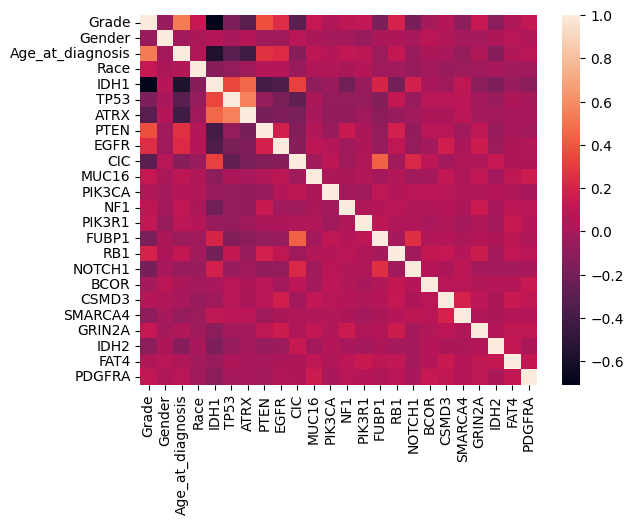

In [7]:
for column in TCGA_InfoWithGrade:
  TCGA_InfoWithGrade[column].astype(float)

sns.heatmap(TCGA_InfoWithGrade.corr())

# Построение модели

## Разделение набора данных
**Y** - целевая переменная, которую предсказываем.  
Мы ищем зависимость этой переменной от соответствующих фич.  
В нашем случае это столбец **Grade**.

В **X** складываем весь набор данных без целевой переменной.

In [8]:
from sklearn import preprocessing

for column in TCGA_InfoWithGrade:
  TCGA_InfoWithGrade[column].astype(float)

X = TCGA_InfoWithGrade.drop(['Grade'], axis=1)
y = TCGA_InfoWithGrade['Grade']
print(f'X shape: {X.shape} | y shape: {y.shape} ')

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y)

X shape: (839, 23) | y shape: (839,) 


## Train Test разделение
Разделяем наш набор данных на обучающий (train) и тестовый (test) с помощью train_test_split(), мы берем 80% данных для обучения нашей модели и 20% оставляем в качестве проверочного набора данных:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded, test_size=0.20, random_state=10)


## Обучение и выбор оптимальной модели
Далее попробуем следующие алгоритмы:

Logistic Regression (LR)\
Linear Discriminant Analysis (LDA)\
K-Nearest Neighbors (KNN)\
Classification and Regression Trees (CART)\
Gaussian Naive Bayes (NB)\
Support Vector Machines (SVM)

In [10]:
from sklearn import svm

models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='auto')))

# оцениваем их метрики
results = []
model_names = []
for name, model in models:
  kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  model_names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.866023 (0.055195)
LDA: 0.871883 (0.035836)
KNN: 0.803336 (0.056309)
CART: 0.812291 (0.051455)
NB: 0.812270 (0.059959)
SVC: 0.827217 (0.043355)


In [12]:
X1 = X_train.drop(['IDH1'], axis=1)


results = []
model_names = []
for name, model in models:
  kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
  cv_results = cross_val_score(model, X1, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  model_names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.806453 (0.047731)
LDA: 0.815342 (0.044472)
KNN: 0.739267 (0.043367)
CART: 0.733363 (0.068512)
NB: 0.704829 (0.065644)
SVC: 0.784065 (0.061129)


## Обучение конкретной модели
Определяем нашу модель LDA После этого подгоняем/обучаем модель на X_train и Y_train с помощью метода .fit(). Затем мы делаем прогноз на X_test с помощью метода .predict().

In [ ]:
sk_lda = LinearDiscriminantAnalysis(solver='eigen')
sk_lda.fit(X_train, y_train)
sk_lda_pred_res = sk_lda.predict(X_test)
sk_transformed = sk_lda.transform(X_train)
sk_lda_accuracy = accuracy_score(y_test, sk_lda_pred_res)

print(f'sk LDA accuracy: {sk_lda_accuracy}')
print(f'sk LDA prediction: {sk_lda_pred_res}')
print('sk transformed features', sk_transformed[:5].T, sep='\n')

sk LDA accuracy: 0.8630952380952381
sk LDA prediction: [0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1
 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0
 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0
 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1]
sk transformed features
[[-2.2554695   1.80380296 -1.02341138 -0.6811552   2.21305411]]


In [ ]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

recall = metrics.recall_score(y_test, sk_lda_pred_res, average="weighted")
precision = metrics.precision_score(y_test, sk_lda_pred_res, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, sk_lda_pred_res, target_names=[str(i) for i in np.unique(y_test)]))

Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.88
Detail:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        97
           1       0.79      0.93      0.85        71

    accuracy                           0.86       168
   macro avg       0.86      0.87      0.86       168
weighted avg       0.88      0.86      0.86       168

